In [20]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

In [21]:
class RWKV_Time_Mixing(torch.nn.Module):
    def __init__(self, embedding_dim, head_dim, num_heads, ctx_len):
        super().__init__()
        self.mu = nn.SiLU() 
        self.Receptance = nn.Linear(embedding_dim, num_heads * head_dim)
        self.Key = nn.Linear(embedding_dim, num_heads * head_dim)
        self.Value = nn.Linear(embedding_dim, num_heads * head_dim)
        self.output = nn.Linear(num_heads * head_dim, embedding_dim)
        
        self.num_heads = num_heads # Кол-во голов
        self.head_dim = head_dim # Размер головы
        self.ctx_len = ctx_len

        with torch.no_grad(): 
            ww = torch.ones(self.num_heads, self.ctx_len)
            curve = torch.tensor([-(self.ctx_len - 1 - i) for i in range(self.ctx_len)]) # the distance
            for h in range(self.num_heads):
                if h < self.num_heads - 1:
                    decay_speed = math.pow(self.ctx_len, -(h + 1)/(self.num_heads - 1))
                else:
                    decay_speed = 0.0
                ww[h] = torch.exp(curve * decay_speed)
        self.time_w = nn.Parameter(ww)
        self.time_alpha = nn.Parameter(torch.ones(self.num_heads, 1, self.ctx_len))
        self.time_beta = nn.Parameter(torch.ones(self.num_heads, self.ctx_len, 1))
        self.time_gamma = nn.Parameter(torch.ones(self.ctx_len, 1))
        self.time_shift = nn.ZeroPad2d((0, 0 , 1 , -1))

    def forward(self, x):
        B, T, C = x.size()

        TT = self.ctx_len
        w = F.pad(self.time_w, (0, TT))
        w = torch.tile(w, [TT])
        w = w[:, :-TT].reshape(-1, TT, 2 * TT - 1)
        w = w[:, :, TT-1:] # w is now a circulant matrix
        w = w[:, :T, :T] * self.time_alpha[:, :, :T] * self.time_beta[:, :T, :]

        x = torch.cat([self.time_shift(x[:, :, :C//2]), x[:, :, C//2:]], dim = -1)

        #--------

        x = self.mu(x) # (batch_size, seq_len, embedding_dim)
        r = torch.sigmoid(self.Receptance(x)) # (batch_size, seq_len, head_dim)
        k = self.Key(x) # (batch_size, seq_len, head_dim)
        v = self.Value(x) # (batch_size, seq_len, head_dim)


        k = torch.exp(k) # Возводим Key в экспоненту для сумм в Attm+(W, K, V) ()
        sum_k = torch.cumsum(k, dim = 1) # Кумулятивная сумма по , (batch_size, seq_len, head_dim)
        kv = (k * v).view(B, T, self.num_heads, self.head_dim) # матричное уможение
        wkv = (torch.einsum('htu,buhc->bthc', w, kv)).contiguous().view(B, T, -1)
        rwkv = wkv / sum_k # делим числитель на знаменатель
        rwkv = self.output(rwkv)

        return rwkv * self.time_gamma[:T, :]

In [22]:
class RWKV_Channel_Mixing(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.mu = nn.SiLU() 
        self.Receptance = nn.Linear(embedding_dim, embedding_dim)
        self.Key = nn.Linear(embedding_dim, hidden_dim)
        self.Value = nn.Linear(embedding_dim, hidden_dim )
        self.Weight = nn.Linear(hidden_dim, embedding_dim)
        self.Mish = nn.Mish()
        self.time_shift = nn.ZeroPad2d((0,0,1,-1))

    def forward(self, x):
        B, T, C = x.size()
        
        x = torch.cat([self.time_shift(x[:, :, :C//2]), x[:, :, C//2:]], dim = -1)
        x = self.mu(x)
        k = self.Key(x)
        v = self.Value(x)
        
        wkv = self.Weight(self.Mish(k) * v)
        r = torch.sigmoid(self.Receptance(x))

        rwkv = r * wkv
        return rwkv

In [23]:
class RWKV_Block(nn.Module):
    def __init__(self, embedding_dim, num_heads, head_dim, ctx_len, hidden_dim):
        super().__init__()

        self.Layer_Norm1 = nn.LayerNorm(embedding_dim)
        self.Layer_Norm2 = nn.LayerNorm(embedding_dim)

        self.timemix = RWKV_Time_Mixing(embedding_dim, head_dim, num_heads, ctx_len)
        self.channelmix = RWKV_Channel_Mixing(embedding_dim, hidden_dim)

    def forward(self, x):
        x = x + self.timemix(self.Layer_Norm1(x))
        x = x + self.channelmix(self.Layer_Norm2(x))
    
        return x

In [24]:
class RWKV_LM_Head(nn.Module):
    def __init__(self, embedding_dim, n_class):
        super().__init__()

        self.Layer_Norm = nn.LayerNorm(embedding_dim)
        self.output = nn.Linear(embedding_dim, n_class)

    def forward(self, x):
        x = self.output(self.Layer_Norm(x))
    
        return x

In [25]:
class RWKV_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, head_dim, ctx_len, hidden_dim, num_layers, n_class):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.Layer_Norm = nn.LayerNorm(embedding_dim)
        self.blocks = nn.Sequential(*[RWKV_Block(embedding_dim, num_heads, head_dim, ctx_len, hidden_dim) for i in range(num_layers)])
        self.lm_head = RWKV_LM_Head(embedding_dim, n_class)

    def forward(self, x):
        x = self.embedding(x)
        x = self.Layer_Norm(x)
        x = self.blocks(x)
        x = self.lm_head(x)
        return x
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Подготовка датасета

In [26]:
batch_size = 8
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 768 // 2
n_head = 12 # D = 384 // 6
n_layer = 12
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [27]:
import re

with open('/kaggle/input/nlp-rwkv-clean/dataset_with_dot_and_coma.txt', 'r') as file:
    lines = file.readlines()

new_lines = []
for line in lines:

    #убрать лишние пробелы в начале строки, оставить только английские буквы, пробелы между словами, знак - разделитель \n

    line = line.lstrip()
    line = re.sub(r'[^a-zA-Z\s\n.,]', '', line)
    if line.isdigit():
        continue
    line = line.replace("\u2005", "").replace("\u2009", "").replace("\u200a", "")
    line = line.replace("\u2002", " ").replace("\u2003", " ").replace("\u202f", " ").replace("\xa0", " ").replace("\u3000", " ").replace("\t", " ")
    
    new_lines.append(line)

with open('dataset_poetry_mac_modified.txt', 'w', encoding = 'MACCYRILLIC') as file:
    file.writelines(new_lines)

with open('dataset_poetry_mac_modified.txt', 'r', encoding = 'MACCYRILLIC') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [28]:
text[:600].split('\n')

['Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be unnecessary, undesirable, and harmful. As a historically leftwing movement, placed on the farthest left of the political spectrum, it is usually described alongside communalism and libertarian Marxism as the libertarian wing libertarian socialism of the socialist movement, and has a strong historical association with anticapitalism and socialism.',
 'Humans lived in societies without formal hie']

In [29]:
len(text) # Количество символов = 213 миллионов

213091159

In [30]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [31]:
loss_val = []

@torch.no_grad()
def estimate_loss():
    criterion = nn.CrossEntropyLoss()
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            Y = Y.view(B * T)
            loss = criterion(logits, Y)
            losses[k] = loss.item()
            loss_val.append(loss.item())
        out[split] = losses.mean()
    model.train()
    return out

# Модель

In [32]:
model = RWKV_model(vocab_size, n_embd, n_head, n_embd, block_size, n_embd, n_layer, vocab_size).to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

92.378168 M parameters


In [33]:
from tqdm import tqdm

## Обучение модели


In [34]:
loss_train = []

try:
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    for iter in tqdm(range(max_iters)):

        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch('train')
        logits = model(xb)
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        yb = yb.view(B * T)
        loss = criterion(logits, yb)
        loss_train.append(loss)
        optimizer.zero_grad(set_to_none = True)
        loss.backward()
        optimizer.step()

except KeyboardInterrupt: 0

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 4.1544, val loss 4.1525


 10%|█         | 501/5000 [03:08<13:12:38, 10.57s/it]

step 500: train loss 1.7629, val loss 1.7690


 20%|██        | 1001/5000 [05:41<11:44:53, 10.58s/it]

step 1000: train loss 1.5877, val loss 1.5881


 30%|███       | 1501/5000 [08:14<10:16:35, 10.57s/it]

step 1500: train loss 1.5043, val loss 1.5145


 40%|████      | 2001/5000 [10:47<8:48:53, 10.58s/it] 

step 2000: train loss 1.4616, val loss 1.4696


 50%|█████     | 2501/5000 [13:20<7:19:55, 10.56s/it]

step 2500: train loss 1.4271, val loss 1.4215


 60%|██████    | 3001/5000 [15:53<5:51:48, 10.56s/it]

step 3000: train loss 1.3941, val loss 1.3980


 70%|███████   | 3501/5000 [18:26<4:23:45, 10.56s/it]

step 3500: train loss 1.3724, val loss 1.3793


 80%|████████  | 4001/5000 [20:59<2:55:46, 10.56s/it]

step 4000: train loss 1.3566, val loss 1.3693


 90%|█████████ | 4501/5000 [23:32<1:27:51, 10.56s/it]

step 4500: train loss 1.3477, val loss 1.3512


100%|█████████▉| 4999/5000 [25:56<00:00,  3.21it/s]  


In [36]:
model.eval()

RWKV_model(
  (embedding): Embedding(56, 384)
  (Layer_Norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): RWKV_Block(
      (Layer_Norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (Layer_Norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (timemix): RWKV_Time_Mixing(
        (mu): SiLU()
        (Receptance): Linear(in_features=384, out_features=4608, bias=True)
        (Key): Linear(in_features=384, out_features=4608, bias=True)
        (Value): Linear(in_features=384, out_features=4608, bias=True)
        (output): Linear(in_features=4608, out_features=384, bias=True)
        (time_shift): ZeroPad2d((0, 0, 1, -1))
      )
      (channelmix): RWKV_Channel_Mixing(
        (mu): SiLU()
        (Receptance): Linear(in_features=384, out_features=384, bias=True)
        (Key): Linear(in_features=384, out_features=384, bias=True)
        (Value): Linear(in_features=384, out_features=384, bias=True)
        (Weight

In [37]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens = 500)[0].tolist()))


International discoveries federable discovery, and more definition, Northwestronomy industries, a political , alternative data is hogoned to be the basis.
White gional servers of historics described protection of a hyperbological skeleton and the notation of accident theory importance in the global roof between an enabling Guin.
PLC with the third among other hunting like Hetape proclares being connected to Old and William Black Challenger in the French film
where she find the Registry of Tannee


In [39]:
text = "Soviet Union"
context = torch.tensor([encode(text)], dtype=torch.long, device=device)

In [41]:
print(decode(model.generate(context, max_new_tokens = 500)[0].tolist()))

Soviet Unions map
Plant for a said colonial airnet after the remains carvice increased full, natural recognation, saw, or nonprofile broad calt airports. Of a full common ethnographic coeffects, northeast, the service and complaint replies the second numbers from flight cails, E and the company, making its value several physics. The Regional Helmufful was clouding of a  Late club, a lotych of the Brixeut Aguntstras annual Enoconced Britains Blithe anandhono urged the broosiegeer celebrations, brandoing the 


In [42]:
loss_train = [el.cpu() for el in loss_train]

In [43]:
loss_train = [el.item() for el in loss_train]

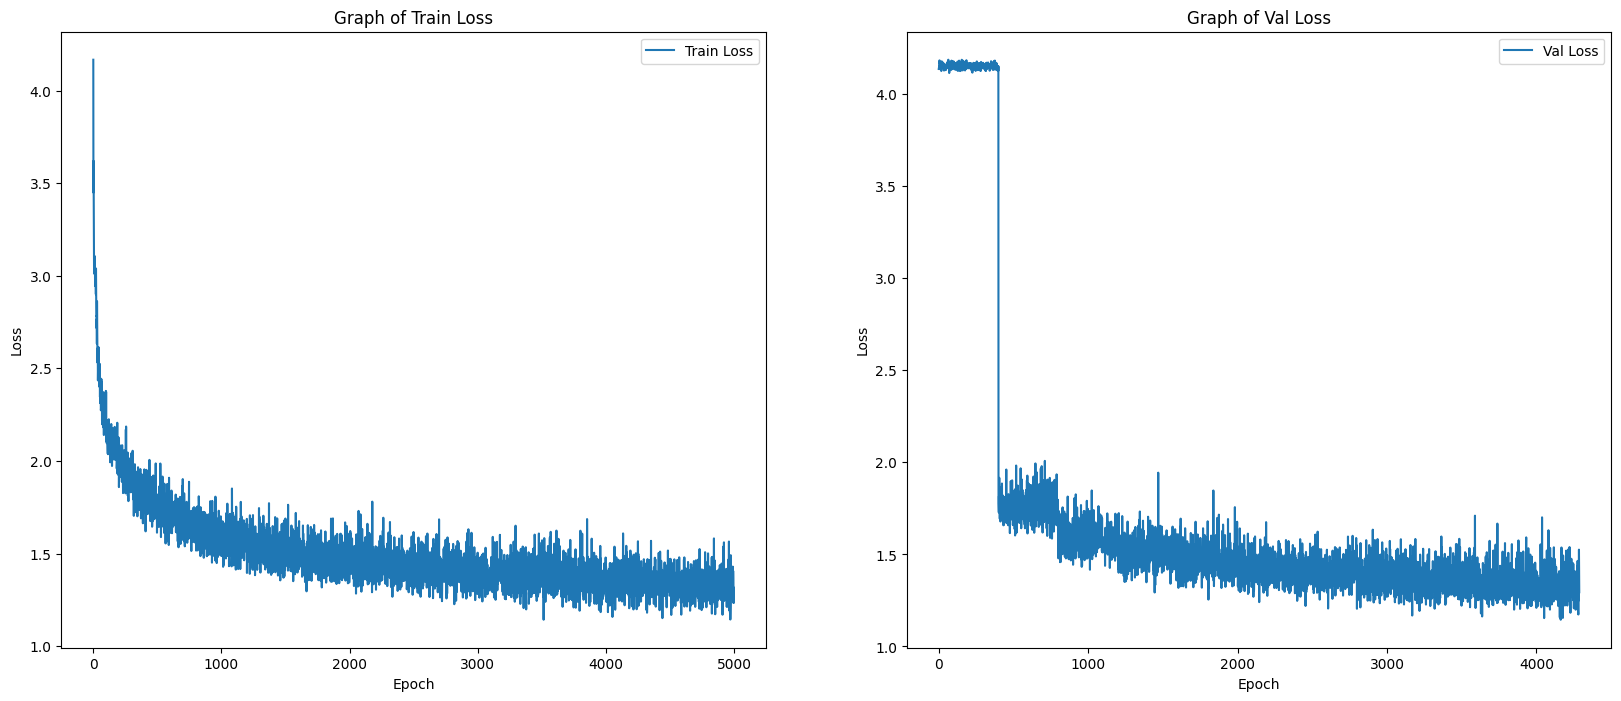

In [44]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax1.plot(loss_train, label='Train Loss')
ax1.set_title('Graph of Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(loss_val, label='Val Loss')
ax2.set_title('Graph of Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.subplots_adjust(hspace=0.5)

plt.show()


In [45]:
torch.save(model, 'rwkv-90m.pth')